### Code Overview and Import Statements

This initial code block imports a series of libraries essential for data handling, geospatial analysis, visualization, and time series forecasting. Below, we outline the purpose of each library and module, noting their specific role in the project. 

#### Core Libraries
- **`json`**: Used to parse and manage JSON-formatted data, which is common in API responses and data files.
- **`time`** and **`os`**: `time` provides time-related functions, including delays and timestamps, which may be useful for handling API rate limits. `os` allows interaction with the operating system, particularly for file path management and directory operations.
- **`requests`**: A popular HTTP library for Python, enabling easy interaction with web APIs to retrieve data from online sources.
  
#### Geospatial and Data Handling Libraries
- **`geopandas` (imported as `gpd`)**: Extends pandas to allow for geospatial data handling, supporting reading, manipulation, and visualization of spatial datasets.
- **`fiona`**: Used to handle geographic data files in various formats, often used in conjunction with `geopandas`.
- **`pandas` (imported as `pd`)**: A foundational data analysis library, essential for handling tabular data structures like DataFrames.

#### Geolocation and Geometry Libraries
- **`geopy.distance` (specifically `geodesic`)**: Calculates distances between geographical points, aiding in distance-based spatial calculations.
- **`shapely.geometry` (specifically `Point`)**: Allows for the creation and manipulation of geometric objects, such as points on a map, facilitating geospatial analysis.

#### Visualization Libraries
- **`matplotlib.pyplot` (imported as `plt`)**: A primary plotting library for creating static, interactive, and animated visualizations in Python.
  
#### Scientific and Statistical Libraries
- **`numpy` (imported as `np`)**: A fundamental library for numerical computing in Python, supporting efficient array operations and mathematical functions.
- **`statsmodels.tsa.arima.model.ARIMA`**: Provides ARIMA (AutoRegressive Integrated Moving Average) for time series analysis, which is useful for forecasting based on historical data.
- **`warnings`**: A utility for managing and filtering warnings, which is helpful to suppress non-critical warnings during model training.

#### Forecasting Library
- **`prophet.Prophet`**: Prophet, developed by Facebook, is a forecasting tool specialized for handling time series data with daily observations. It allows for easy inclusion of seasonal effects, holidays, and uncertainty intervals.


This setup ensures that we have all necessary tools to handle data retrieval, geospatial analysis, and predictive modeling for smoke and AQI estimates. Each library has a distinct purpose, facilitating a comprehensive, reproducible workflow from data acquisition to visualization and prediction.


In [1]:
import json
import time
import os
import requests
import geopandas as gpd
import fiona
import pandas as pd
from geopy.distance import geodesic
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from prophet import Prophet

/Users/nard_doggo/anaconda3/envs/gis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Exploring Layers in the Geodatabase (GDB) File

In this code block, we define the path to a geodatabase (GDB) file and list all available layers within it. This step is essential for understanding the structure and contents of the GDB file, which will guide us in selecting relevant layers for further analysis.

1. **Specify GDB File Path**:
   - `gdb_path` is defined as the path to the `.gdb` file, `"Fire_Feature_Data.gdb"`, which contains multiple layers of geographic and attribute data related to fire features.
   
2. **List Available Layers**:
   - We use `fiona.listlayers(gdb_path)` to retrieve and list all layers in the specified GDB file. Fiona’s `listlayers` function provides an overview of each layer, which could include information on fire types, locations, geometries, etc.
   - Printing `layers` outputs a list of layer names, helping us identify which layers are available for use in the analysis.

3. **Commentary on Reproducibility**:
   - Ensure that the specified path, `gdb_path`, is accurate and accessible in the environment where the code is executed. Path-related issues can hinder reproducibility if the file structure or naming conventions differ.
   - This block enhances reproducibility by providing transparency regarding the data layers available in the GDB, allowing other researchers to verify or adjust the layers they may need for their specific analyses.



In [2]:
# Path to the .gdb file
gdb_path = "../data/Fire_Feature_Data.gdb"

# List all available layers in the geodatabase (GDB) file using Fiona
layers = fiona.listlayers(gdb_path)
print("Available layers:", layers)

Available layers: ['USGS_Wildland_Fire_Combined_Dataset', 'USGS_Wildland_Fires_Overlapping_Fire_Data', 'USGS_Wildland_Fire_Merged_Dataset']


### Loading and Inspecting Fire Data Layer

In this code block, we load a specific layer from the geodatabase file to access wildfire data and inspect its structure.

1. **Load Fire Data Layer**:
   - `gpd.read_file(gdb_path, layer="USGS_Wildland_Fire_Combined_Dataset")` uses `geopandas` to load the `"USGS_Wildland_Fire_Combined_Dataset"` layer from the GDB file.
   - This step creates a `GeoDataFrame`, `fire_data`, that contains both attribute and spatial information related to wildland fires.

2. **Inspect Column Names**:
   - `fire_data.columns` lists all column names in the `GeoDataFrame`, providing an overview of the available attributes for each fire record.
   - The column names reveal the scope of the dataset and help identify relevant attributes, such as fire type, location, date, and size, which are essential for analysis.

In [3]:
# Load the specific layer 'USGS_Wildland_Fire_Combined_Dataset' from the GDB file
fire_data = gpd.read_file(gdb_path, layer="USGS_Wildland_Fire_Combined_Dataset")

# Display the column names in the loaded GeoDataFrame
fire_data.columns

/Users/nard_doggo/anaconda3/envs/gis_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


Index(['USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

### Coordinate Reference System (CRS) Check and Reprojection

This code block ensures that the wildfire data's spatial information is in a standardized CRS, which is crucial for consistency, especially when combining multiple spatial datasets.

1. **Print Original CRS**:
   - `print("Original CRS:", fire_data.crs)` outputs the current CRS of `fire_data`. Knowing the CRS at the start is essential, as it affects spatial operations like measuring distances or overlaying data on maps.

2. **Conditional Reprojection to "EPSG:4326"**:
   - The condition `if fire_data.crs != "EPSG:4326"` checks if the dataset’s CRS differs from "EPSG:4326" (WGS 84), a widely used geographic coordinate system.
   - If a transformation is needed, `fire_data.to_crs("EPSG:4326")` reprojects the data to WGS 84, standardizing latitude and longitude coordinates.
   - Reprojecting to a common CRS simplifies spatial alignment with other datasets, as different projections can cause misalignment and calculation errors.

3. **Verification of the New CRS**:
   - `print("New CRS:", fire_data.crs)` confirms the CRS after any reprojection, ensuring spatial consistency across analyses.

4. **Dataset Dimension Check**:
   - `print(len(fire_data.columns))` provides the number of columns in `fire_data`, giving a quick insight into the dataset's structure and breadth.


In [4]:
# Print the original Coordinate Reference System (CRS) of the fire_data GeoDataFrame
print("Original CRS:", fire_data.crs)

# Check if the CRS is different from the commonly used "EPSG:4326" (WGS 84).
# If different, reproject the GeoDataFrame to "EPSG:4326" for consistency.
if fire_data.crs != "EPSG:4326":
    fire_data = fire_data.to_crs("EPSG:4326")

# Confirm the new CRS of the GeoDataFrame after reprojection (if it occurred)
print("New CRS:", fire_data.crs)

# Print the number of columns in the GeoDataFrame for a quick overview of dataset dimensions
print(len(fire_data.columns))

Original CRS: PROJCS["North_America_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102008"]]
New CRS: EPSG:4326
30


In [5]:
fire_data.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Big Quilcene River (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"MULTIPOLYGON (((-123.03391 47.82097, -123.0337..."
1,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Harrison Lake (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"MULTIPOLYGON (((-123.05861 47.76009, -123.0597..."
2,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Tunnel Creek (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"MULTIPOLYGON (((-123.09627 47.77931, -123.0973..."
3,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",1870 (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"MULTIPOLYGON (((-115.76194 46.05639, -115.7581..."
4,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",No Fire Name Provided (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"MULTIPOLYGON (((-114.27934 43.9222, -114.27936..."


### Calculating Distance from Fires to a Specified City

This code block calculates the distance in miles between each fire's location and Jackson, MS, based on each fire's geometry centroid. Such distances help in assessing the spatial proximity of wildfires to the city, which is relevant for analyzing potential air quality impacts.

1. **Define City Coordinates**:
   - `city_coords = (32.32, -90.21)` specifies the latitude and longitude of Jackson, MS.
   - `city_point = Point(city_coords[1], city_coords[0])` creates a point geometry for the city using the Shapely library, which aids in geometric calculations.

2. **Distance Calculation Function**:
   - `calculate_distance(fire_geometry, city_point)` is a custom function that:
     - Determines the centroid of the fire geometry.
     - Computes the geodesic distance (great-circle distance) between the fire's centroid and the city center, with output in miles.
   - `geodesic` from the `geopy.distance` module is used for accurate distance measurements along the Earth's surface.

3. **Applying the Function to the Dataset**:
   - `fire_data['geometry'].apply(lambda x: calculate_distance(x, city_point))` applies the `calculate_distance` function to each fire's geometry in the dataset.
   - The computed distances are stored in a new column, `distance_to_city`, making it easy to reference proximity metrics for analysis.


In [6]:
# Define city coordinates for Jackson, MS
city_coords = (32.32, -90.21)
city_point = Point(city_coords[1], city_coords[0])

# Define a function to calculate distance from a fire's location to the city center
def calculate_distance(fire_geometry, city_point):
    # Get the centroid of the fire's geometry
    fire_center = fire_geometry.centroid
    # Calculate the geodesic distance (in miles) between the city center and the fire's center
    distance = geodesic((city_point.y, city_point.x), (fire_center.y, fire_center.x)).miles
    return distance

# Apply the distance calculation function to each fire's geometry in the dataset
fire_data['distance_to_city'] = fire_data['geometry'].apply(lambda x: calculate_distance(x, city_point))


### Histogram of Fire Distances from City with Modeling Distance Cut-off

This visualization shows the distribution of wildfires by their distance from Jackson, MS, up to 1800 miles away. Here, we analyze how frequently fires occur at various distances to understand their spatial distribution in relation to the city, providing insights into which fires are more likely to impact air quality.

1. **Plotting the Histogram**:
   - `plt.hist()` creates a histogram that groups fires into 50-mile distance bins, up to 1800 miles.
   - Each bin represents a 50-mile interval, with the number of fires falling within that interval shown on the y-axis.
   - We use light blue bars with black edges for visibility.

2. **Indicating the Modeling Distance Cut-off**:
   - A vertical dashed red line (`plt.axvline(650, ...)`) marks the 650-mile cut-off distance specified for the modeling work. This line highlights the range within which fires are considered significant for air quality modeling.

3. **Labels, Title, and Legend**:
   - X-axis (`Distance from City (miles)`) shows distance bins.
   - Y-axis (`Number of Fires`) displays the count of fires within each bin.
   - A title (`Distribution of Fires by Distance from City`) describes the plot content.
   - `plt.legend()` includes a label for the cut-off line, aiding in plot interpretation.


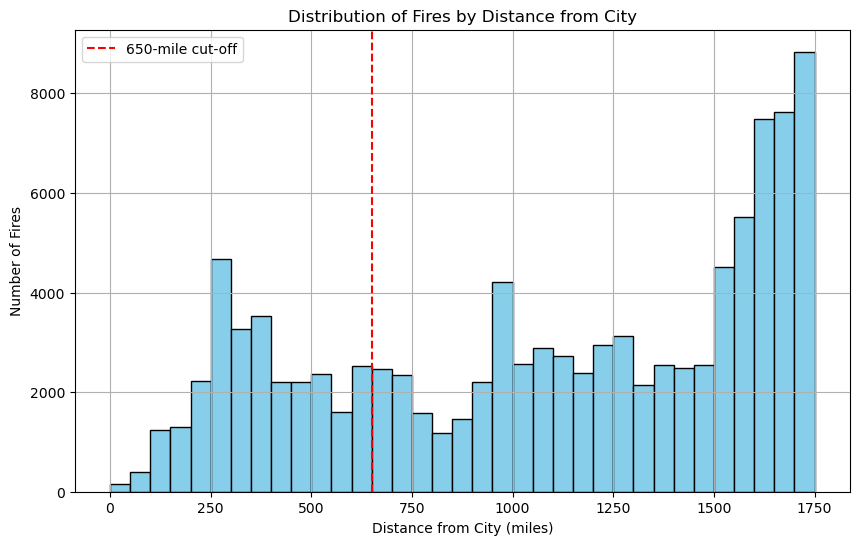

In [7]:
plt.figure(figsize=(10, 6))

# Plotting a histogram of fire distances, with 50-mile bin intervals
plt.hist(fire_data['distance_to_city'], bins=range(0, 1800, 50), color='skyblue', edgecolor='black')

# Adding a vertical line at the 650-mile cut-off to visually indicate modeling distance limit
plt.axvline(650, color='red', linestyle='--', label='650-mile cut-off')

# Setting labels and title
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Distribution of Fires by Distance from City')

# Adding legend and grid for readability
plt.legend()
plt.grid(True)
plt.show()


### Filtering Fire Data by Distance and Year Range

This code filters the fire dataset to include only the records that meet the following criteria:
1. **Distance to City**:
   - We limit the dataset to fires occurring within a 650-mile radius from Jackson, MS, as specified in the analysis requirements.
   
2. **Year Range**:
   - Only fires between 1961 and 2021 are retained. This range aligns with the study's temporal scope and is chosen based on data availability and relevance for longitudinal analysis.


In [8]:
# Filtering the fire data for fires within 650 miles and within the specified year range
fire_data_within_distance = fire_data[
    (fire_data['distance_to_city'] <= 650) & 
    (fire_data['Fire_Year'] >= 1961) & 
    (fire_data['Fire_Year'] <= 2021)
]

### Calculating Smoke Impact Based on Fire Type, Size, and Distance

This code block defines a function to estimate the smoke impact of each fire record based on multiple factors such as fire type, size, distance from the city, and shape. Each factor influences the estimated smoke impact, and the formula used for this calculation is specified below.

#### Mathematical Formula for Smoke Impact Calculation

The smoke impact for each fire is computed as:

\[
\text{smoke\_impact} = \frac{\text{GIS\_Acres} \times \text{Circleness\_Scale}}{\text{distance\_to\_city}^2} \times \text{fire\_type\_weight}
\]

where:
- **GIS_Acres**: The area of the fire in acres.
- **Circleness_Scale**: A measure indicating the circularity of the fire's shape.
- **distance_to_city**: The distance from the fire location to the assigned city, in miles.
- **fire_type_weight**: A weight assigned to each fire type, capturing the likelihood or intensity of smoke production.

#### Steps in the Code

1. **Smoke Impact Calculation**:
   - The function `calculate_smoke_impact` calculates smoke impact for each row based on the factors mentioned above.
   
2. **Fire Type Weights**:
   - Fire types such as "Wildfire" and "Likely Wildfire" are assigned higher weights (e.g., 1.0, 0.9) than "Prescribed Fire," reflecting the higher smoke potential of wildfires.

3. **Applying the Calculation**:
   - The function is applied to each row in `fire_data_within_distance` using `apply`, adding a new `smoke_impact` column to store the calculated values.

4. **Result Validation**:
   - Displaying the first few rows of the DataFrame allows verification of the calculation, ensuring that the `smoke_impact` values are computed correctly.


### Intuition Behind Smoke Impact Calculation

The smoke impact calculation estimates how fires contribute to urban smoke exposure based on four key factors:

#### 1. **Fire Size**  
   - **Larger Fires → Higher Smoke Impact**: Bigger fires produce more smoke due to the increased burning area.

#### 2. **Shape**  
   - **More Circular Fires → Consistent Dispersion**: Fires with uniform shapes may have more predictable smoke patterns.

#### 3. **Distance**  
   - **Closer Fires → Greater Impact**: Smoke dissipates with distance, so closer fires affect nearby cities more.

#### 4. **Fire Type**  
   - **Wildfires > Prescribed Fires**: Wildfires are assigned higher weights due to their intense smoke production.

In [9]:
def calculate_smoke_impact(row, fire_type_weights):
    # Weight by fire type
    fire_type_weight = fire_type_weights.get(row['Assigned_Fire_Type'], 1.0)
    # Calculate smoke impact with Circleness_Scale included
    return (row['GIS_Acres'] * row['Circleness_Scale'] / (row['distance_to_city']**2)) * fire_type_weight

# Define fire type weights (example values)
fire_type_weights = {
    'Wildfire': 1.0,
    'Unknown - Likely Wildfire': 0.9,
    'Likely Wildfire': 0.8,
    'Prescribed Fire': 0.5,
    'Unknown - Likely Prescribed Fire': 0.3
}

# Apply the smoke impact formula
fire_data_within_distance['smoke_impact'] = fire_data.apply(lambda row: calculate_smoke_impact(row, fire_type_weights), axis=1)
fire_data_within_distance.head()


/Users/nard_doggo/anaconda3/envs/gis_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry,distance_to_city,smoke_impact
13778,13779,Wildfire,1961,1,"1 (1), 3 (1)",28.693900,11.612009,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),W_C_H_4_3_W1_61 (2),...,None,None,0.648984,NaN,No,1499.483528,116120.094413,"MULTIPOLYGON (((-83.71589 35.67573, -83.71587 ...",438.703886,0.000097
13792,13793,Wildfire,1961,1,"1 (1), 3 (1)",13.973044,5.654690,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),FALL BRANC (2),...,None,None,0.580768,NaN,No,1106.134803,56546.901627,"MULTIPOLYGON (((-83.73666 35.65839, -83.73651 ...",437.011521,0.000042
13809,13810,Wildfire,1961,1,"1 (1), 3 (1)",6.655655,2.693448,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),WORLEY KNO (2),...,None,None,0.745906,NaN,No,673.623387,26934.479311,"MULTIPOLYGON (((-83.41782 35.46031, -83.41759 ...",446.202348,0.000025
13810,13811,Wildfire,1961,1,"1 (1), 3 (1)",6.387265,2.584835,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),CW_H_4_2_W12_61 (2),...,None,None,0.761103,NaN,No,653.280533,25848.346042,"MULTIPOLYGON (((-83.9443 35.60967, -83.94426 3...",425.121768,0.000027
13812,13813,Wildfire,1961,1,"1 (1), 3 (1)",5.278596,2.136172,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),NIAGRA (2),...,None,None,0.405355,NaN,No,813.777277,21361.722055,"MULTIPOLYGON (((-96.94984 34.50159, -96.94959 ...",417.382788,0.000012


### Aggregating Annual Smoke Impact

In this code block, we calculate the total smoke impact for each year by summing the smoke impact values across all fires that occurred in a given year. This produces an annual summary of smoke impact, useful for time-series analysis and predicting future trends.

#### Explanation of the Process

1. **Grouping by Year**:
   - The data is grouped by the `Fire_Year` column, allowing us to aggregate data on a yearly basis.
   
2. **Summing Smoke Impact**:
   - For each year, we calculate the total smoke impact by summing the `smoke_impact` values of all fires within that year.

3. **Renaming Columns**:
   - The resulting DataFrame has columns renamed to `Year` and `Total_Smoke_Impact` for clarity, making it easy to interpret the data.


In [10]:
# Group the data by 'Fire_Year' and sum the 'smoke_impact' to get annual totals
annual_smoke_impact = fire_data_within_distance.groupby('Fire_Year')['smoke_impact'].sum().reset_index()

# Rename columns for clarity
annual_smoke_impact.columns = ['Year', 'Total_Smoke_Impact']

# Save the some impact data to a csv
annual_smoke_impact.to_csv('../data/smoke_impact.csv', sep=',', index=False)


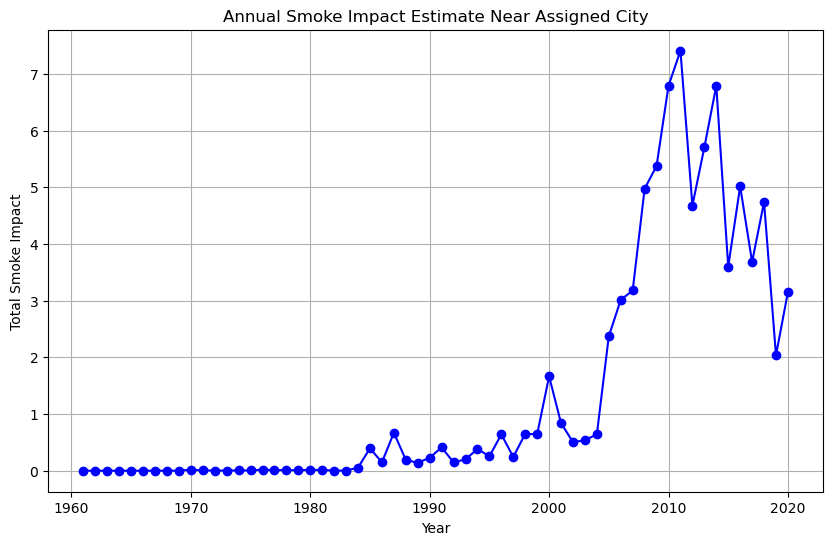

In [11]:
# Plotting the Annual Smoke Impact

plt.figure(figsize=(10, 6))
plt.plot(annual_smoke_impact['Year'], annual_smoke_impact['Total_Smoke_Impact'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Total Smoke Impact')
plt.title('Annual Smoke Impact Estimate Near Assigned City')
plt.grid(True)
plt.show()


### Visualization of Total Acres Burned Per Year

This code block creates a time-series line plot illustrating the annual trend in total acres burned for fires that occurred within a 650-mile radius of the assigned city. The purpose of this visualization is to highlight the fluctuations in burn area over time, helping identify years with higher fire activity within the specified distance.

#### Breakdown of the Plot

**Data Aggregation:**

- The line `annual_acres_burned = fire_data_within_distance.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()` groups the filtered fire data by `Fire_Year` and calculates the total `GIS_Acres` burned per year. This DataFrame summarizes annual fire activity in terms of total acreage affected.

**Figure Size and Line Plot:**

- The parameter `figsize=(10, 6)` sets the plot dimensions, while `plt.plot(...)` plots the aggregated data, using markers (`marker='o'`) to highlight each data point. An orange line (`color='orange'`) represents the yearly burn totals with a continuous line (`linestyle='-'`).

**Axis Labels and Title:**

- The x-axis (`xlabel`) represents `Year`, and the y-axis (`ylabel`) represents `Total Acres Burned`, aiding in quick interpretation.
- The plot title, `Total Acres Burned per Year within 650 Miles of City`, succinctly describes the visualized data.

**Gridlines:**

- `plt.grid(True)` adds gridlines for enhanced readability, enabling easier tracing of values across the time axis.


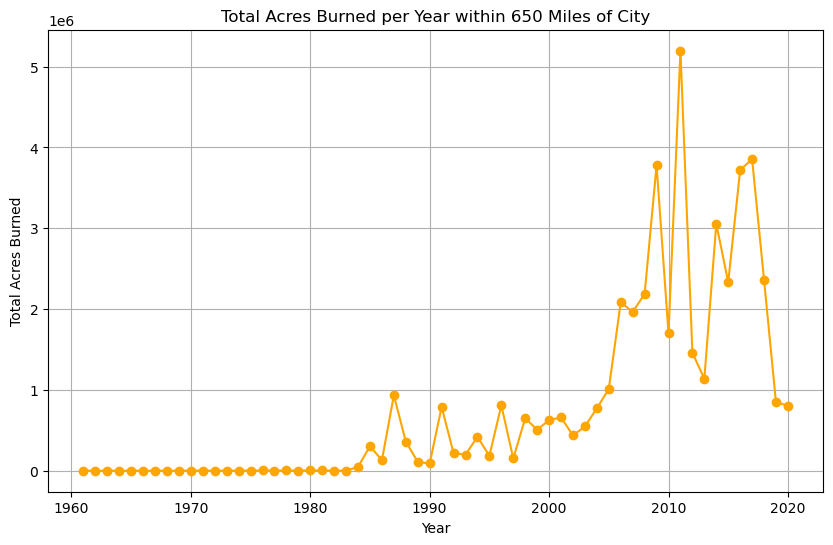

In [12]:
# Aggregating Total Acres Burned Per Year
annual_acres_burned = fire_data_within_distance.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

# Plotting the Total Acres Burned Per Year
plt.figure(figsize=(10, 6))
plt.plot(annual_acres_burned['Fire_Year'], annual_acres_burned['GIS_Acres'], marker='o', linestyle='-', color='orange')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year within 650 Miles of City')
plt.grid(True)
plt.show()

### Setting Up Constants and Bounding Box for AQI Data Retrieval

This code defines constants and parameters to retrieve AQI data within a specified bounding box around Jackson, MS, for analysis.

#### Overview of Key Components

1. **API URL and Action Paths**:
   - `API_REQUEST_URL`: Base URL for the EPA's AQI API.
   - `API_ACTION_DAILY_SUMMARY_BBOX`: Endpoint for retrieving daily AQI data using a geographic bounding box (latitude and longitude coordinates).
   
2. **File Paths for AQI Data**:
   - `TEST_AQI_DATA_FILE`: Path for saving raw AQI data fetched within the bounding box.
   - `CLEAN_AQI_DATA_FILE`: Path for storing processed, clean AQI data for analysis.

3. **AQI Parameters**:
   - `AQI_PARAMS_GASEOUS` and `AQI_PARAMS_PARTICULATES` define codes for pollutants (e.g., CO, SO2, NO2, O3, PM10, PM2.5) to retrieve from the API.

4. **API Credentials**:
   - `USERNAME` and `APIKEY` are placeholders for the user's API access credentials, essential for authorized data requests.

5. **City Coordinates and Bounding Box Setup**:
   - `city_lat` and `city_lon`: Latitude and longitude coordinates for Jackson, MS.
   - **Bounding Box Calculation (50 Miles)**:
     - Defines constants for latitude and longitude distances covering 25 miles each.
     - Calculates a bounding box centered around Jackson, MS, by expanding 50 miles outwards in each direction (`min_lat`, `max_lat`, `min_lon`, and `max_lon`). This area captures data within a reasonable radius for localized AQI analysis relevant to wildfire impacts or urban AQI trends.

These definitions ensure that all API requests target the correct geographic area, pollutants, and data storage locations. Using a bounding box helps to focus data collection on regions most relevant to the assigned city, facilitating efficient data retrieval for spatially-focused AQI analysis.


In [13]:
# Define constants for the API and file paths
API_REQUEST_URL = "https://aqs.epa.gov/data/api"
API_ACTION_DAILY_SUMMARY_BBOX = "/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={min_lat}&maxlat={max_lat}&minlon={min_lon}&maxlon={max_lon}"
AQI_DATA_FILE = "../data/raw_aqi_data.csv"  # File to store raw AQI data with bounding box
CLEAN_AQI_DATA_FILE = "../data/clean_aqi_data.csv"  # File to store cleaned AQI data

# AQI parameters for gaseous and particulate pollutants
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"  # CO, SO2, NO2, O3
AQI_PARAMS_PARTICULATES = "81102,88101,88502"  # PM10, PM2.5

# Replace with your API credentials
USERNAME = "trips@uw.edu"
APIKEY = "saffronheron23"

# Jackson, MS coordinates
city_lat = 32.32
city_lon = -90.21

# Define bounding box calculations (50 miles)
LAT_25MILES = 25.0 * (1.0 / 69.0)
LON_25MILES = 25.0 * (1.0 / 54.6)
min_lat = city_lat - 6 * LAT_25MILES
max_lat = city_lat + 6 * LAT_25MILES
min_lon = city_lon - 6 * LON_25MILES
max_lon = city_lon + 6 * LON_25MILES

### Function to Request and Store Daily AQI Data Within a Bounding Box

This code block defines two functions to retrieve and store AQI data for a specified bounding box surrounding a city (Jackson, MS) from the EPA's AQI API.

#### Function: `request_daily_summary_bbox`

This function constructs and sends an API request to fetch daily AQI data for a specific bounding box and time range.

- **Parameters**:
  - `email` and `key`: API credentials for authorization.
  - `param`: AQI parameter codes, specifying pollutants to fetch.
  - `year`: The year for which data is being requested, defining the start (`begin_date`) and end (`end_date`) dates.
  - `min_lat`, `max_lat`, `min_lon`, `max_lon`: Latitude and longitude bounds for the bounding box.

- **Process**:
  - Constructs the API request URL with bounding box coordinates.
  - Pauses briefly (`time.sleep(0.1)`) between requests to respect API rate limits.
  - Returns the API response as JSON data for processing.

#### Function: `fetch_and_store_aqi_data`

This function iterates over a range of years, invoking `request_daily_summary_bbox` to gather AQI data across multiple years. It saves the data to a CSV file.

- **Parameters**:
  - Same as `request_daily_summary_bbox` plus `start_year` and `end_year`, defining the data range.

- **Process**:
  - Iterates through each year within the range, calling `request_daily_summary_bbox`.
  - For each successful API response, it converts the data to a pandas DataFrame (`df`) and appends it to a list.
  - If any data is collected, combines all years' data (`combined_df`) and saves to `TEST_AQI_DATA_FILE`.

#### Checking for Existing Data File

- Before fetching data, the code checks if `TEST_AQI_DATA_FILE` already exists locally. If so, it skips data fetching to save on API requests and computational time.

### Example Use Case

Running this code collects and stores AQI data within a specified bounding box around Jackson, MS, across a range of years (1961–2021). This data can be further analyzed to assess long-term trends or pollution impacts near the specified location.

### Code Comments and Explanation

- `if not os.path.exists(TEST_AQI_DATA_FILE)`: Prevents redundant API calls if data is already saved locally.
- `print` statements provide feedback, indicating whether new data is fetched or if the existing file is used.

This setup facilitates spatially and temporally focused AQI data retrieval for specific pollutants, allowing efficient analysis of AQI patterns in a bounded geographic region.


In [14]:
# Function to request daily AQI data within bounding box
def request_daily_summary_bbox(email, key, param, year, min_lat, max_lat, min_lon, max_lon):
    begin_date = f"{year}0101"
    end_date = f"{year}1231"
    request_url = API_REQUEST_URL + API_ACTION_DAILY_SUMMARY_BBOX.format(
        email=email, key=key, param=param, begin_date=begin_date, end_date=end_date, 
        min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon
    )
    response = requests.get(request_url)
    time.sleep(0.1)
    return response.json()

# Function to fetch and store AQI data in CSV format
def fetch_and_store_aqi_data(email, key, param, start_year, end_year, min_lat, max_lat, min_lon, max_lon):
    all_aqi_data = []  # Collect all data rows

    for year in range(start_year, end_year + 1):
        aqi_data = request_daily_summary_bbox(email, key, param, year, min_lat, max_lat, min_lon, max_lon)
        if aqi_data["Header"][0]["status"] == "Success":
            df = pd.DataFrame(aqi_data["Data"])
            print(f"Fetched data for {year}: {len(df)} records")
            all_aqi_data.append(df)
        else:
            print(f"Error fetching AQI data for year {year}: {aqi_data['Header'][0]['status']}")
    
    # Combine all years' data into a single DataFrame
    if all_aqi_data:
        combined_df = pd.concat(all_aqi_data, ignore_index=True)
        combined_df.to_csv(AQI_DATA_FILE, index=False)
        print(f"Data saved to {AQI_DATA_FILE}")

# Check if data file already exists, else fetch from API
if not os.path.exists(AQI_DATA_FILE):
    print("Fetching AQI data from EPA API within bounding box...")
    fetch_and_store_aqi_data(USERNAME, APIKEY, f"{AQI_PARAMS_GASEOUS},{AQI_PARAMS_PARTICULATES}", 1961, 2021, min_lat, max_lat, min_lon, max_lon)
else:
    print(f"AQI data already exists in {AQI_DATA_FILE}.")

AQI data already exists in ../data/raw_aqi_data.csv.


### Processing and Transforming AQI Data for Analysis

This section describes the steps to load, process, and transform daily AQI data into annual averages for specified pollutants. The resulting dataset is saved as a clean CSV file with columns for each pollutant's yearly average concentration. This transformation is designed to facilitate time-series analysis and trend evaluation.

#### Step-by-Step Breakdown

1. **Load Raw AQI Data**  
   - The AQI data is loaded from `AQI_DATA_FILE`, which contains daily AQI records within a geographic bounding box.

2. **Date Conversion and Year Extraction**  
   - The `date_local` column is converted to a datetime format to easily extract the `Year` for annual aggregation.

3. **Annual Aggregation of Pollutant Data**  
   - Using group-by operations, the data is grouped by `Year` and `parameter_code`, calculating the mean `arithmetic_mean` for each pollutant per year. This step condenses the dataset into annual summaries, facilitating a yearly comparison of pollutant concentrations.

4. **Data Reshaping with Pivot**  
   - A pivot operation is applied, structuring the data with `Year` as rows and `parameter_code` values as columns. Each cell now represents the average annual concentration of a particular pollutant.

5. **Parameter Mapping for Readability**  
   - Pollutant `parameter_code` values are mapped to descriptive names:
     - `42101` -> **CO** (Carbon Monoxide)
     - `42401` -> **SO2** (Sulfur Dioxide)
     - `42602` -> **NO2** (Nitrogen Dioxide)
     - `44201` -> **O3** (Ozone)
     - `81102` -> **PM10** (Particulate Matter <10 µm)
     - `88101` -> **PM2.5** (Particulate Matter <2.5 µm)  
   - This mapping improves data readability and accessibility.

6. **Resetting the Index**  
   - The `Year` column is restored as a regular column (not an index) for a standard DataFrame format, making the data suitable for further manipulation and analysis.

7. **Saving the Transformed Data**  
   - The transformed dataset is saved to `CLEAN_AQI_DATA_FILE`. This cleaned file contains annual pollutant averages, making it ideal for visualizing trends or incorporating into predictive models.

#### Resulting Output

The cleaned data, saved in `CLEAN_AQI_DATA_FILE`, now contains yearly pollutant concentration averages in a structured and readable format. This format supports reproducible analysis, ensuring pollutant trends can be easily accessed and analyzed over time.

In [15]:
# Load the AQI data
aqi_data = pd.read_csv(AQI_DATA_FILE)

# Convert 'date_local' to datetime to extract the year
aqi_data['date_local'] = pd.to_datetime(aqi_data['date_local'])
aqi_data['Year'] = aqi_data['date_local'].dt.year

# Group by 'Year' and 'parameter_code' to calculate average 'arithmetic_mean' for each pollutant per year
annual_aqi = aqi_data.groupby(['Year', 'parameter_code'])['arithmetic_mean'].mean().reset_index()

# Pivot the data to have one column per 'parameter_code' with the average values
annual_aqi_pivot = annual_aqi.pivot(index='Year', columns='parameter_code', values='arithmetic_mean')

# Mapping parameter codes to human-readable pollutant names
parameter_mapping = {
    42101: 'CO',      # Carbon Monoxide
    42401: 'SO2',     # Sulfur Dioxide
    42602: 'NO2',     # Nitrogen Dioxide
    44201: 'O3',      # Ozone
    81102: 'PM10',    # Particulate Matter <10 micrometers
    88101: 'PM2.5'    # Particulate Matter <2.5 micrometers
}

# Apply the mapping for clearer column names
annual_aqi_pivot.rename(columns=parameter_mapping, inplace=True)

# Reset the index to make 'Year' a regular column
annual_aqi_pivot.reset_index(inplace=True)

# Display the transformed DataFrame
print(annual_aqi_pivot.head(60))
annual_aqi_pivot.to_csv(CLEAN_AQI_DATA_FILE, index=False)
print(f"Cleaned AQI data saved to {CLEAN_AQI_DATA_FILE}")

/var/folders/k_/b_4q2c_s5414zkj7bjt65szw0000gn/T/ipykernel_9554/1216498272.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  aqi_data = pd.read_csv(AQI_DATA_FILE)


parameter_code  Year        CO        SO2        NO2        O3       PM10  \
0               1967       NaN  10.000000        NaN       NaN        NaN   
1               1968       NaN   4.631373        NaN       NaN        NaN   
2               1969       NaN   5.212500        NaN       NaN        NaN   
3               1970       NaN   3.014583        NaN       NaN        NaN   
4               1971  0.631100   5.384152  23.762077       NaN        NaN   
5               1972  0.848958  11.275592  20.410758  0.013159        NaN   
6               1973  0.195326   5.189728  26.198281  0.015923        NaN   
7               1974  2.066697   5.012833  17.983732  0.019146        NaN   
8               1975  1.508267   3.965456  15.704368  0.020053        NaN   
9               1976       NaN   4.771563  17.120761  0.024968        NaN   
10              1977       NaN   5.092412  16.443001  0.028163        NaN   
11              1978  2.222046   6.510723  16.777004  0.029224        NaN   

### Calculating a Weighted AQI Estimate

This code block calculates a weighted AQI (Air Quality Index) estimate for each year in the dataset, with greater emphasis on more impactful pollutants. The resulting AQI estimate considers only valid pollutants per row, adjusting weights dynamically based on available data, which ensures accuracy in cases of missing values.

#### Step-by-Step Breakdown

1. **Load the Cleaned AQI Data**  
   - The AQI data is loaded from `clean_aqi_data.csv`, which contains annual averages for specified pollutants.

2. **Define Pollutant Weights**  
   - A dictionary `pollutant_weights` is defined to assign weights to pollutants based on their relative importance:
     - **PM2.5**: 0.7 (highest priority due to health impact)
     - **PM10**: 0.1
     - **CO**: 0.1
     - **O3**: 0.1

3. **Weighted AQI Calculation Function**  
   - `calculate_weighted_aqi(row, weights)`: For each row, this function calculates a weighted AQI estimate by:
     - Filtering out pollutants that are missing (`NaN`) to ensure calculations are based only on valid values.
     - Normalizing weights to ensure they sum to 1 for the row's available pollutants.
     - Calculating the weighted AQI by summing each pollutant’s concentration, multiplied by its adjusted weight.

4. **Apply Function to DataFrame**  
   - The weighted AQI calculation is applied to each row in `aqi_data`, generating a new column `Weighted_AQI_Estimate`.

5. **Display and Save Results**  
   - The first 30 rows of `Year`, pollutant concentrations, and `Weighted_AQI_Estimate` are printed to verify results.
   - The DataFrame is saved as `weighted_aqi_estimate.csv` for further analysis or reporting if required.

#### Resulting Output

The output dataset includes a `Weighted_AQI_Estimate` column that provides a comprehensive AQI value for each year, taking into account the relative impact of individual pollutants. This approach provides a more refined AQI metric, allowing for year-over-year comparisons that emphasize pollutants with the most significant health implications.


In [16]:
aqi_data = pd.read_csv('../data/clean_aqi_data.csv')

# Define the pollutant weights
pollutant_weights = {
    'PM2.5': 0.7,
    'PM10': 0.1,
    'CO': 0.1,
    'O3': 0.1
}

# Function to calculate the weighted AQI estimate
def calculate_weighted_aqi(row, weights):
    # Collect valid pollutants and their weights
    valid_pollutants = {pollutant: row[pollutant] for pollutant in weights if pd.notna(row[pollutant])}
    valid_weights = {pollutant: weight for pollutant, weight in weights.items() if pollutant in valid_pollutants}
    
    # Normalize weights to sum to 1 for the current row (in case of missing pollutants)
    total_weight = sum(valid_weights.values())
    normalized_weights = {pollutant: weight / total_weight for pollutant, weight in valid_weights.items()}
    
    # Calculate the weighted average
    weighted_aqi = sum(normalized_weights[pollutant] * valid_pollutants[pollutant] for pollutant in valid_pollutants)
    return weighted_aqi

# Apply the function across the DataFrame
aqi_data['Weighted_AQI_Estimate'] = aqi_data.apply(calculate_weighted_aqi, axis=1, weights=pollutant_weights)

# Display the result
print(aqi_data[['Year', 'PM2.5', 'PM10', 'CO', 'O3', 'Weighted_AQI_Estimate']].head(30))

# Save the result if needed
aqi_data.to_csv('../data/weighted_aqi_estimate.csv', index=False)

    Year  PM2.5       PM10        CO        O3  Weighted_AQI_Estimate
0   1967    NaN        NaN       NaN       NaN               0.000000
1   1968    NaN        NaN       NaN       NaN               0.000000
2   1969    NaN        NaN       NaN       NaN               0.000000
3   1970    NaN        NaN       NaN       NaN               0.000000
4   1971    NaN        NaN  0.631100       NaN               0.631100
5   1972    NaN        NaN  0.848958  0.013159               0.431059
6   1973    NaN        NaN  0.195326  0.015923               0.105624
7   1974    NaN        NaN  2.066697  0.019146               1.042921
8   1975    NaN        NaN  1.508267  0.020053               0.764160
9   1976    NaN        NaN       NaN  0.024968               0.024968
10  1977    NaN        NaN       NaN  0.028163               0.028163
11  1978    NaN        NaN  2.222046  0.029224               1.125635
12  1979    NaN        NaN  1.259049  0.023718               0.641384
13  1980    NaN     

### Time Series Visualization of Fire Smoke Impact and AQI Estimates

This section visualizes a comparative time series plot of annual fire smoke impact and AQI estimates for the assigned city. By overlaying these two metrics, the plot highlights trends in air quality and smoke impact over time, allowing for easy comparison of fire-related pollution levels with AQI estimates.

#### Step-by-Step Breakdown

1. **Combine Data Sources**  
   - `combined_data = pd.merge(annual_smoke_impact, aqi_data, on='Year', how='inner')` merges `annual_smoke_impact` and `aqi_data` on the `Year` column to align fire smoke impact with AQI estimates for the same years. This inner join ensures only common years are included, providing consistency in time-series analysis.

2. **Configure Plot Layout and Dimensions**  
   - `plt.figure(figsize=(12, 6))` sets the figure size to 12x6 inches, ensuring readability.

3. **Plot Fire Smoke Estimates**  
   - `plt.plot(...)` plots the `Total_Smoke_Impact` with a green line and markers. This line represents the estimated impact of wildfire smoke on air quality, emphasizing yearly variations.

4. **Plot AQI Estimates**  
   - Another `plt.plot(...)` line plot is used to represent `Weighted_AQI_Estimate` in red, providing a visual of annual AQI trends within the same context as fire smoke impacts.

5. **Add Labels and Legend**  
   - The x-axis (`plt.xlabel`) and y-axis (`plt.ylabel`) are labeled as Year and Estimate, respectively.
   - The title `Annual Fire Smoke Impact and AQI Estimates for the City` concisely describes the plotted data.
   - `plt.legend()` includes a legend to distinguish between Fire Smoke Impact and AQI Estimate lines, enhancing interpretability.

6. **Enable Grid for Improved Readability**  
   - `plt.grid(True)` adds a grid to facilitate tracking values across the time axis.

7. **Display the Plot**  
   - `plt.show()` renders the plot, displaying overlapping trends in fire smoke and AQI over time.

#### Resulting Visualization

The final time-series plot displays both fire smoke impacts and AQI estimates for each year, making it easier to observe relationships between fire events and changes in air quality in the specified city. This visualization provides insights into the correlation between fire smoke impact and overall air quality, supporting further analysis or predictive modeling.


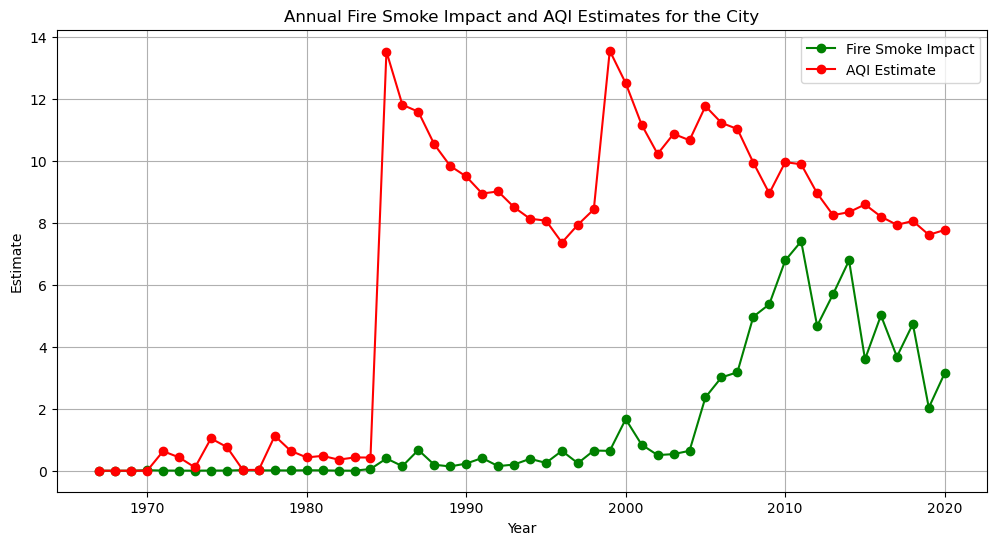

In [17]:
combined_data = pd.merge(annual_smoke_impact, aqi_data, on='Year', how='inner')

# Plotting the time series
plt.figure(figsize=(12, 6))

# Plot fire smoke estimates
plt.plot(combined_data['Year'], combined_data['Total_Smoke_Impact'], label='Fire Smoke Impact', color='green', marker='o', linestyle='-')

# Plot AQI estimates
plt.plot(combined_data['Year'], combined_data['Weighted_AQI_Estimate'], label='AQI Estimate', color='red', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.title('Annual Fire Smoke Impact and AQI Estimates for the City')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [18]:

# Calculate the correlation between Total_Smoke_Impact and Weighted_AQI_Estimate
correlation = combined_data[['Total_Smoke_Impact', 'Weighted_AQI_Estimate']].corr().iloc[0, 1]
print(f"Correlation between Total_Smoke_Impact and Weighted_AQI_Estimate: {correlation}")



Correlation between Total_Smoke_Impact and Weighted_AQI_Estimate: 0.4125277056821127


### Forecasting Smoke Impact for 2025-2050 Using ARIMA

This section demonstrates the use of an ARIMA model to forecast annual smoke impact for the years 2025-2050. Given the historical smoke impact data, the model estimates future values along with a 95% confidence interval. However, note that the forecast appears as a straight line due to the lack of seasonal or periodic data in the historical dataset, which limits the model’s ability to capture complex seasonal patterns.

#### Step-by-Step Breakdown

1. **ARIMA Model Fitting**  
   - `model = ARIMA(annual_smoke_impact['Total_Smoke_Impact'], order=(1, 1, 1))` fits an ARIMA model on the `Total_Smoke_Impact` data, with `(p=1, d=1, q=1)` parameters. These parameters define the autoregressive, differencing, and moving average components, respectively.
   - The model is then fit to the data using `fitted_model = model.fit()`.

2. **Generate Forecast and Confidence Intervals**  
   - Using `get_forecast(steps=25)`, the model produces a 25-year forecast for 2025-2050, alongside the confidence intervals at a 95% level. 
   - `forecast` holds the predicted mean values, and `conf_int` captures the lower and upper bounds of the forecast.

3. **Prepare Forecast Data for Plotting**  
   - A `forecast_years` Series is created to represent the years 2025-2050.
   - `forecast_df` compiles the forecasted smoke impact (`Forecasted_Smoke_Impact`) along with the confidence intervals (`Lower_CI`, `Upper_CI`) into a structured DataFrame for visualization.

4. **Plotting Historical and Forecasted Smoke Impact**  
   - `plt.plot(...)` plots the historical smoke impact with observed data, while the forecasted smoke impact appears as a continuous line for future years, emphasizing expected trends.
   - A shaded area (`plt.fill_between(...)`) represents the 95% confidence interval, visually indicating forecast uncertainty.
   - Labels, title, legend, and gridlines (`plt.grid(True)`) are added for clarity.

#### Resulting Visualization

The resulting plot provides a straightforward forecast for smoke impact from 2025 to 2050, with a 95% confidence interval. Due to limited seasonal data in the historical records, the ARIMA model forecasts a linear trend, lacking significant fluctuations or seasonal variation. This approach underscores the impact of data periodicity on forecast detail, highlighting the limitations in cases without discernible seasonality.

#### Forecasted Data with Confidence Intervals

The table below summarizes the forecasted values for each year from 2025-2050, including lower and upper confidence bounds to convey the uncertainty of predictions.



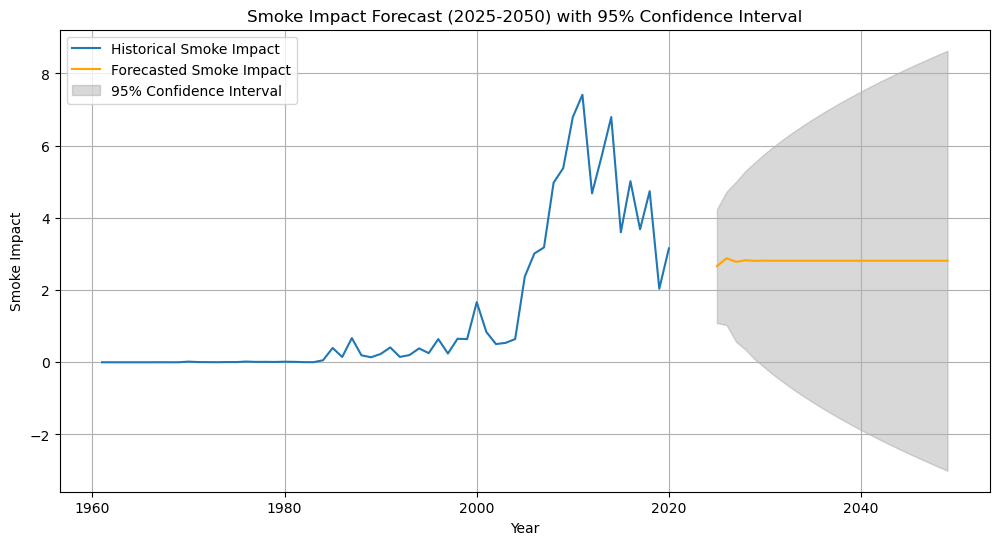

    Year  Forecasted_Smoke_Impact  Lower_CI  Upper_CI
0   2025                 2.662159  1.082851  4.241468
1   2026                 2.879729  1.033223  4.726235
2   2027                 2.783593  0.563910  5.003277
3   2028                 2.826072  0.344192  5.307952
4   2029                 2.807302  0.066024  5.548580
5   2030                 2.815596 -0.153377  5.784569
6   2031                 2.811931 -0.372251  5.996113
7   2032                 2.813551 -0.570617  6.197718
8   2033                 2.812835 -0.760800  6.386470
9   2034                 2.813151 -0.940122  6.566424
10  2035                 2.813011 -1.111804  6.737827
11  2036                 2.813073 -1.276044  6.902191
12  2037                 2.813046 -1.434043  7.060135
13  2038                 2.813058 -1.586326  7.212442
14  2039                 2.813053 -1.733530  7.359636
15  2040                 2.813055 -1.876108  7.502218
16  2041                 2.813054 -2.014480  7.640588
17  2042                 2.8

In [19]:
# Ensure 'Year' is set as the index for time series analysis
#annual_smoke_impact.set_index('Year', inplace=True)

# Fit an ARIMA model on 'Total_Smoke_Impact' (adjust p, d, q parameters based on the data)
model = ARIMA(annual_smoke_impact['Total_Smoke_Impact'], order=(1, 1, 1))
fitted_model = model.fit()

# Use get_forecast() to retrieve forecast and confidence intervals
forecast_results = fitted_model.get_forecast(steps=25)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)

# Prepare forecast data with 25 years for 2025-2050
forecast_years = pd.Series(range(2025, 2025 + 25))
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecasted_Smoke_Impact': forecast.values,
    'Lower_CI': conf_int.iloc[:, 0].values,
    'Upper_CI': conf_int.iloc[:, 1].values
})

# Reset index of annual_smoke_impact for plotting
annual_smoke_impact.reset_index(inplace=True)

# Plotting forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(annual_smoke_impact['Year'], annual_smoke_impact['Total_Smoke_Impact'], label='Historical Smoke Impact')
plt.plot(forecast_df['Year'], forecast_df['Forecasted_Smoke_Impact'], color='orange', label='Forecasted Smoke Impact')
plt.fill_between(forecast_df['Year'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Impact')
plt.title('Smoke Impact Forecast (2025-2050) with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

# Display the forecasted values with confidence intervals
print(forecast_df)


### Forecasting Smoke Impact Using Prophet to Address ARIMA Limitations

This code block uses Facebook’s Prophet model to predict smoke impact for the years 2025-2050. Prophet is chosen over ARIMA to better handle non-linear trends and produce more flexible forecasts, especially useful when historical data lacks strong seasonality or autocorrelation patterns. Prophet's ability to model irregular time series data with yearly projections makes it a strong alternative to the limitations encountered with ARIMA.

#### Step-by-Step Breakdown

1. **Prepare Data for Prophet**  
   - The `annual_smoke_impact` DataFrame is renamed to meet Prophet’s column naming conventions, where `Year` becomes `ds` (date) and `Total_Smoke_Impact` becomes `y` (value).
   - The `ds` column is formatted as datetime for compatibility with Prophet.

2. **Initialize and Fit the Model**  
   - `Prophet(weekly_seasonality=False)` initializes the Prophet model without weekly seasonality to focus solely on yearly trends.
   - The model is trained on the historical smoke impact data with `model.fit(df)`.

3. **Create Future Data for Prediction**  
   - A future DataFrame is created with `model.make_future_dataframe(periods=25, freq='Y')`, extending the time series by 25 years (2025-2050).

4. **Generate and Display Forecast**  
   - `model.predict(future)` generates forecasts for the future years, including confidence intervals for uncertainty estimation.
   - The forecast output, including predicted values (`yhat`) and 95% confidence intervals (`yhat_lower` and `yhat_upper`), is displayed for inspection.

5. **Plot Forecasted Smoke Impact**  
   - The forecast is plotted, with a title and labeled axes to clarify the estimated smoke impact for future years.
   - Prophet’s flexible trend modeling is visually evident, overcoming the ARIMA model’s limitation of producing a straight-line forecast due to lack of seasonality in the data.

#### Advantages of Using Prophet Over ARIMA

Prophet’s ability to model data with irregular seasonal patterns or non-linear growth allows for a more realistic forecast of smoke impact. The visualization highlights potential future trends, with an adaptive forecast line and shaded confidence intervals, enhancing interpretability and providing insight into expected variations.

#### Forecast Results

The output displays the predicted smoke impact values (`yhat`) for each year from 2025-2050, including lower and upper bounds to represent forecast uncertainty.


18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing


           ds      yhat  yhat_lower  yhat_upper
60 2020-12-31  3.793755    2.124588    5.529905
61 2021-12-31  4.205385    2.338528    5.856925
62 2022-12-31  4.251711    2.525913    5.931159
63 2023-12-31  3.925877    2.283431    5.629192
64 2024-12-31  4.327478    2.696493    6.104629
65 2025-12-31  4.149342    2.472429    5.781219
66 2026-12-31  4.144766    2.381492    5.832684
67 2027-12-31  4.541945    2.749469    6.271909
68 2028-12-31  4.700398    3.036219    6.436203
69 2029-12-31  4.612743    2.947287    6.382143
70 2030-12-31  4.678490    2.965720    6.428723
71 2031-12-31  4.485903    2.860733    6.243905
72 2032-12-31  5.316467    3.647009    7.086358
73 2033-12-31  5.370094    3.679171    7.145157
74 2034-12-31  5.051410    3.389299    6.760843
75 2035-12-31  4.949304    3.161001    6.776965
76 2036-12-31  5.260425    3.502852    7.184319
77 2037-12-31  5.263149    3.354284    6.978054
78 2038-12-31  5.667479    3.965728    7.340603
79 2039-12-31  5.706655    4.056738    7

/Users/nard_doggo/anaconda3/envs/gis_env/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


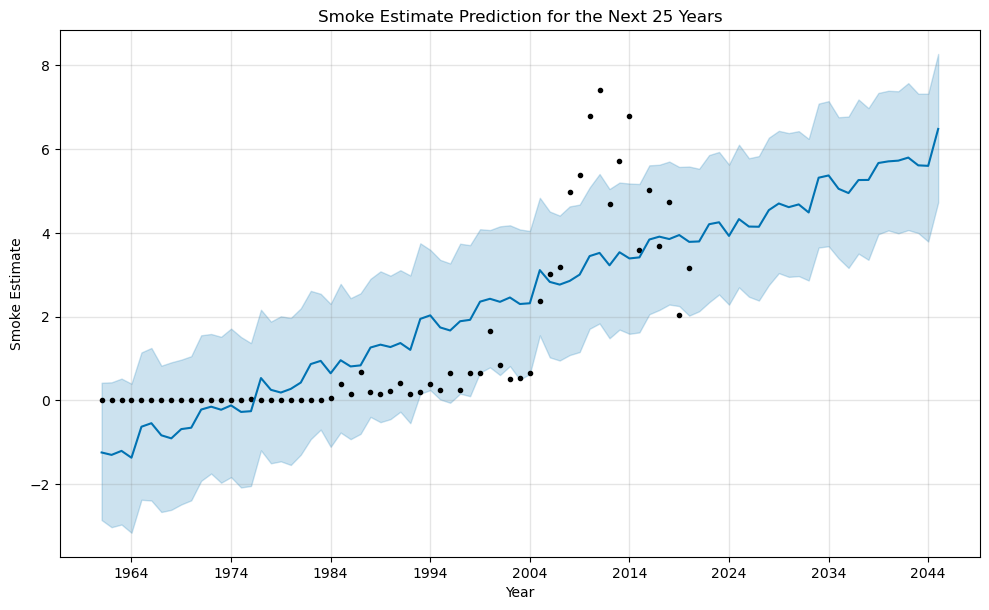

In [20]:
# Rename columns to match Prophet's expected column names
df = annual_smoke_impact.rename(columns={'Year': 'ds', 'Total_Smoke_Impact': 'y'})

# Convert 'ds' to datetime format if it's not already
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True)
model.fit(df)

# Create a future DataFrame for predictions (25 years into the future)
future = model.make_future_dataframe(periods=25, freq='Y')

# Make predictions
forecast = model.predict(future)

# Display the forecasted results for the next 25 years
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(25))

# Plot the forecast
fig = model.plot(forecast)
plt.title('Smoke Estimate Prediction for the Next 25 Years')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()
